In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [66]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from datetime import timedelta
import random

# Get the current date as a string in the format "YYYY-MM-DD"

# Download historical stock price and additional feature data


imploded_stocks = pd.read_csv('filtered_tickers.csv')
imploded_stocks = imploded_stocks['Ticker'].tolist()

sp500_stocks = pd.read_csv('spx500.csv')
sp500_stocks = sp500_stocks['Symbol'].tolist()
start_date = '2009-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

Helper Functions:

In [67]:
def get_stock_price(ticker):
    temp_df = yf.download(ticker, start=start_date, end=end_date)
    if temp_df.empty:
        print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last()
    return weekly_data

def save_weekly_prices(stock_list):
    full_df= pd.DataFrame()
    for t in stock_list:
        t_df = get_stock_price(t)
        if t_df is not None:
            full_df[t] = t_df
    full_df.to_csv('imploded_stock_prices.csv')

def get_random_stock_ticker(stock_list):
   
    random_ticker = random.choice(stock_list)

    return random_ticker




## Crash Detection

The method we use for crash detection is to check for (firm-specific) returns that are in the 0.1% of deepest crashes.

In [89]:
def get_firm_specific_returns(weekly_data):
    returns = weekly_data.pct_change()
    return returns
    market_df = get_stock_price('^GSPC') #what market index should i use?
    market_returns = market_df.pct_change()
    market_returns = market_returns.to_frame()
    market_returns.rename(columns={'Adj Close': 'rt-2'}, inplace=True)
    market_returns['rt-1'] = market_returns['rt-2'].shift(1)
    market_returns['rt'] = market_returns['rt-2'].shift(2)
    market_returns['rt+1'] = market_returns['rt-2'].shift(3)
    market_returns['rt+2'] = market_returns['rt-2'].shift(4)
    market_returns['firm_returns'] = returns
    market_returns.dropna(inplace=True)
    market_returns['firm_specific_returns'] = 0
    y_values = []
    X_values = []

    for date, row in market_returns.iterrows():
        y = market_returns.loc[date, 'firm_returns'].reshape(-1, 1) #num of rows unknown  but cols must be 1
        X = market_returns.loc[date, ['rt-2', 'rt-1', 'rt', 'rt+1', 'rt+2']].values.reshape(1, -1)
        y_values.append(y)
        X_values.append(X)

    lr = LinearRegression()
    lr.fit(np.vstack(X_values), np.vstack(y_values))
    y_fits = lr.predict(np.vstack(X_values))
    epsilon = np.vstack(y_values) - y_fits

    for i, date in enumerate(market_returns.index):
        market_returns.loc[date, 'firm_specific_returns'] = np.log(1 + epsilon[i])

    return market_returns['firm_specific_returns']

def get_crash_dates(firm_returns):
    crash_dates = []
    for i in range(52,len(firm_returns)):
        current_date = firm_returns.index[i]
        current_ret = firm_returns.iloc[i]
        prev_year_data = firm_returns.iloc[i-52:i]
        if len(prev_year_data) != 0:
            mean_ret = prev_year_data.mean()
            std_ret= prev_year_data.std()
            #threshold = mean_ret + norm.ppf(0.005)*std_ret
            #(current_ret - mean_ret)/mean_ret < -0.8
            if (current_ret - mean_ret)/mean_ret < -0.6:
                crash_dates.append(current_date)
    return crash_dates

def plot_crashes(ticker):
    stock_series = get_stock_price(ticker)
    if stock_series is not None:
        #firm_returns = get_firm_specific_returns(stock_series)
        crash_dates = get_crash_dates(stock_series)
        plt.figure(figsize=(15, 5))
        plt.plot(stock_series.index, stock_series, label=ticker)
        for x1 in crash_dates:
            plt.axvspan(x1, x1, alpha=0.5, color='blue')
        plt.legend()
        plt.show()

#returns doesnt seem to work

Checking the number of imploded stocks that crash

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


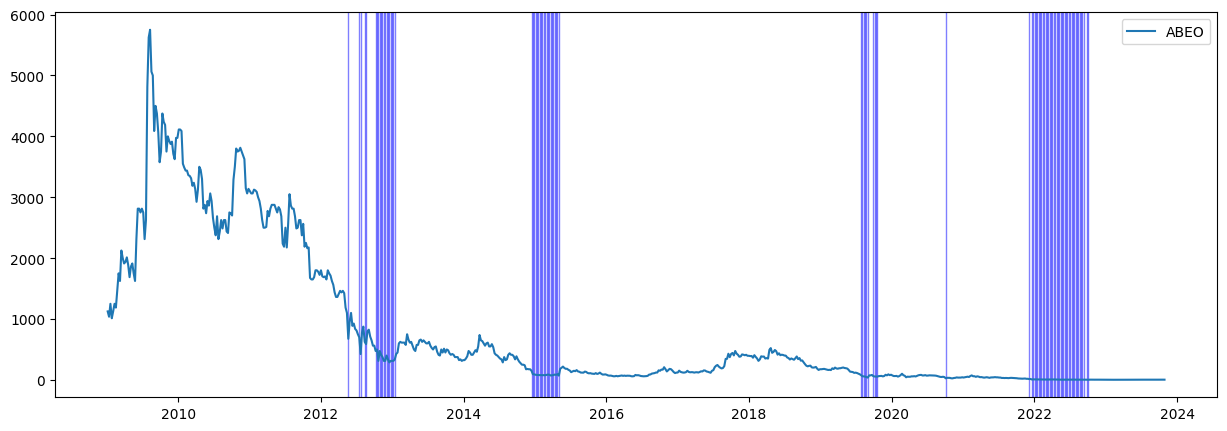

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


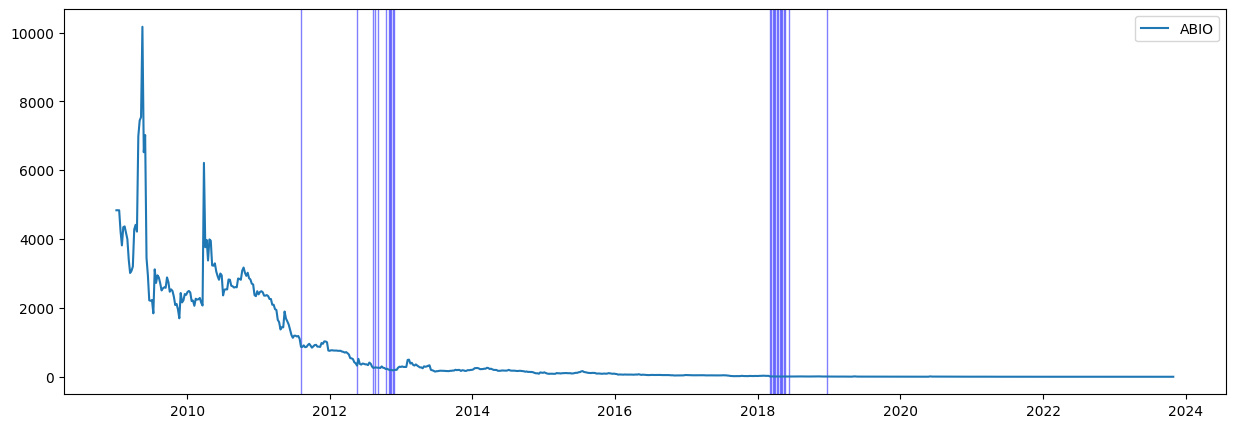

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


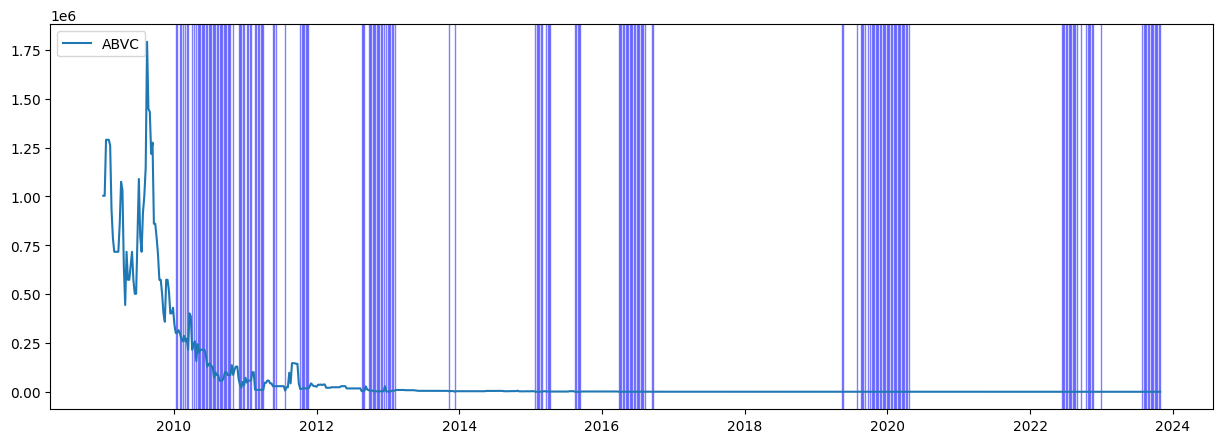

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


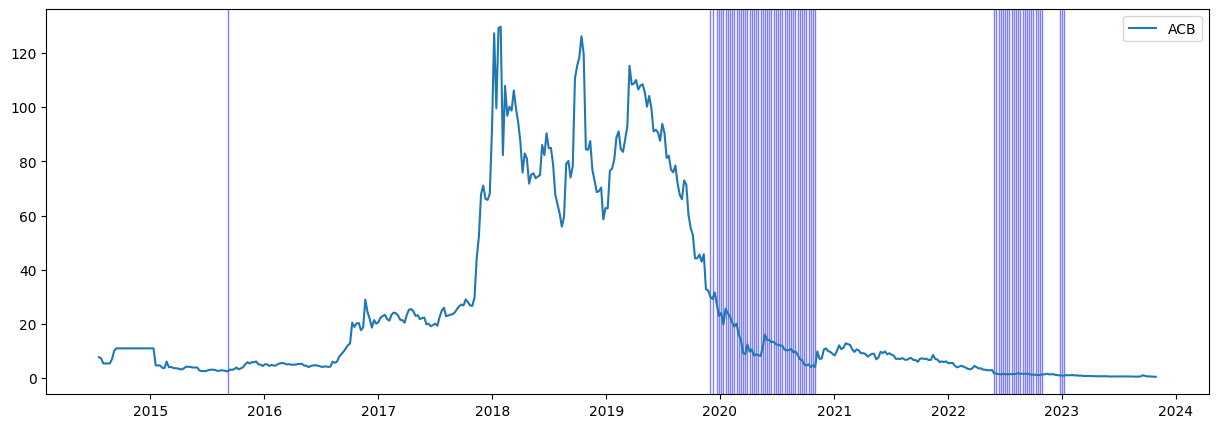

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


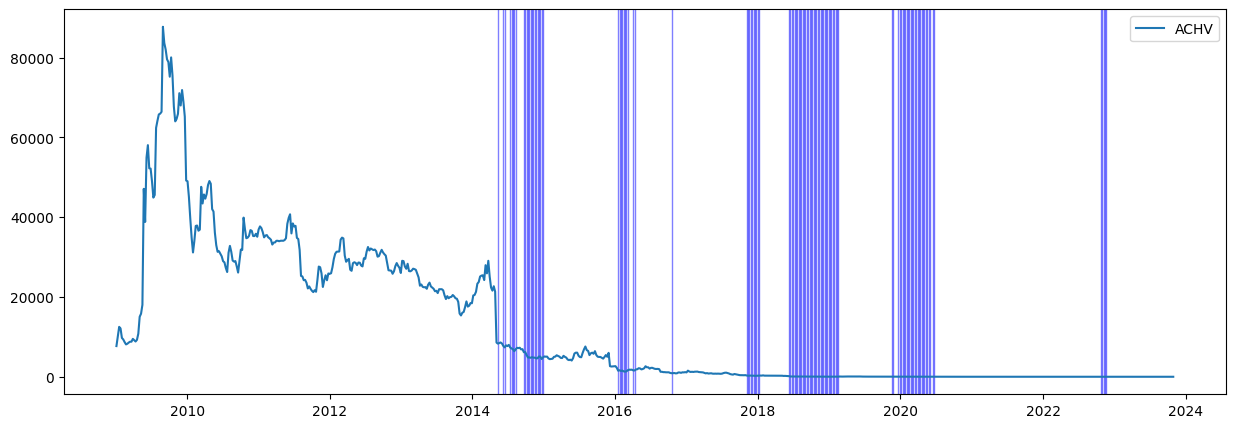

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


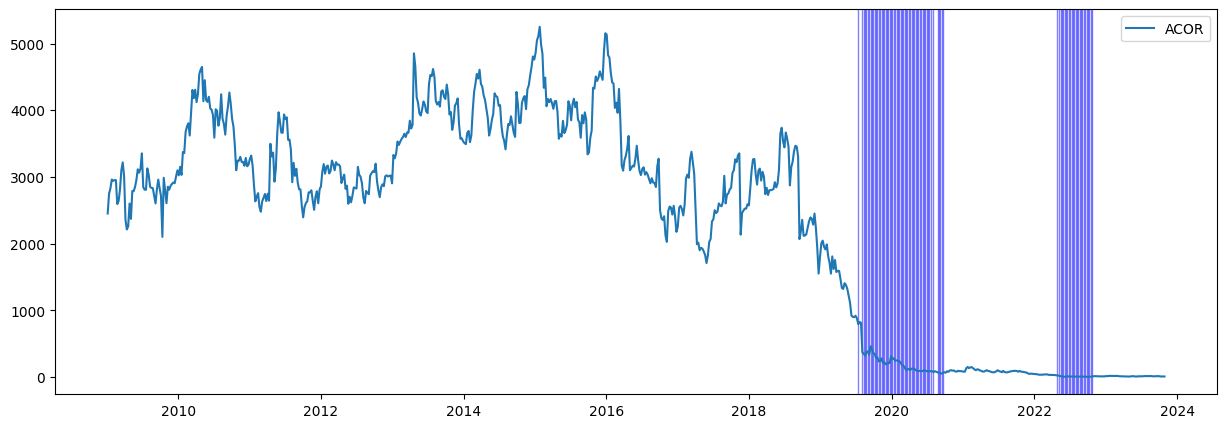

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


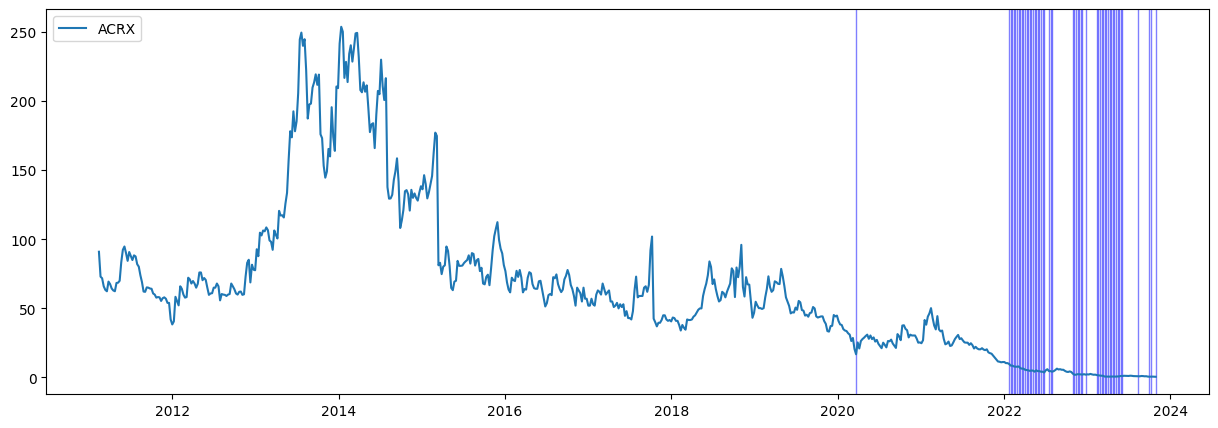

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


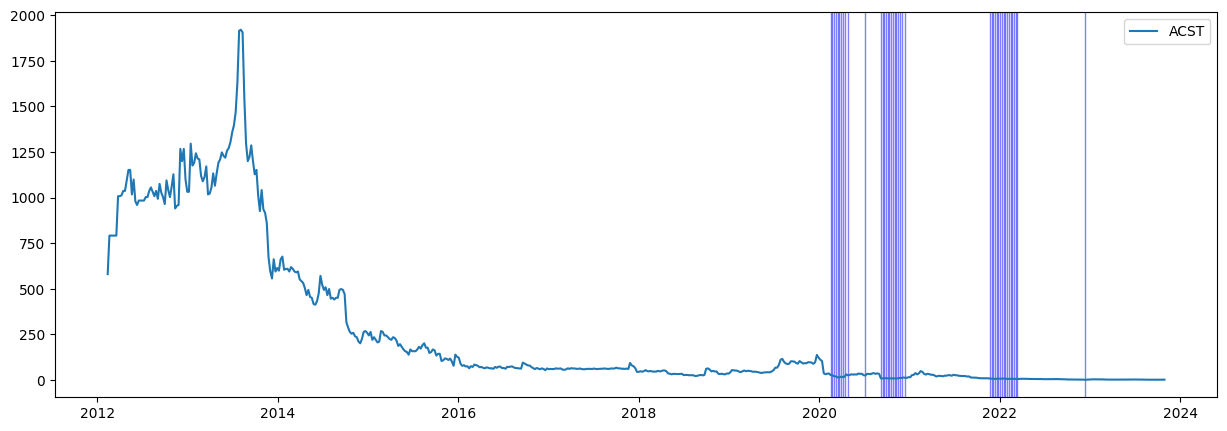

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


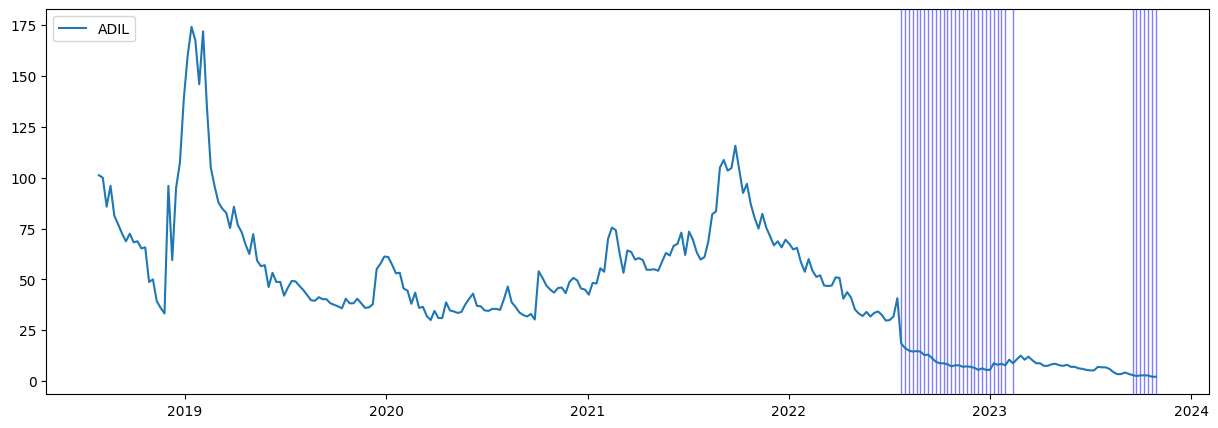

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


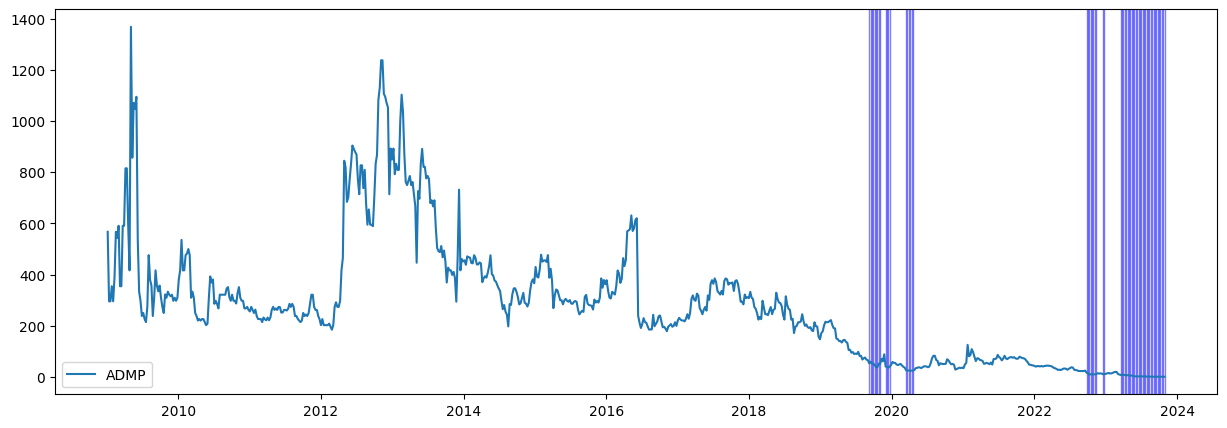

10 out of 433 experienced crashes


In [92]:
def does_stock_crash(ticker):
    stock_series = get_stock_price(ticker)
    if stock_series is not None:
        #firm_returns = get_firm_specific_returns(stock_series)
        crash_dates = get_crash_dates(stock_series)
        if len(crash_dates) == 0:
            return False
        else:
            return True

num_imp = 0
    
for t in imploded_stocks[:10]:
    if does_stock_crash(t):
        num_imp+=1
        plot_crashes(t)

print(f'{num_imp} out of {len(imploded_stocks)} experienced crashes')

At 0.5% level 427/433 imploded stocks experience crashes using (previous) year mean as threshold

Problem with using returns - 0.1% dist - labels crashes that aren't really that strong
Problem using price - multiple dates next to each other - i think this is fine though

Using 80% drop, weekly stock price, previous year price yields 406/433 stocks suffering crashes
Using 80% drop, weekly stock price, previous year price yields 9/505 sp500 stocks suffering crashes
Using 60% drop, weekly stock price, previous year price yields 424/433 impoded stocks suffering crashes

Extra test on test branch


## Implosion Detection

## Testing detection on Imploded Stocks vs S&P500 stocks